# BNN vs GP for regression on Molecules

Here we will compare the regression of molecules for the given datasets using BNN with GPs. Here we rely on Bayesian linear layers with variational estimator from BLiTZ (https://github.com/piEsposito/blitz-bayesian-deep-learning). This can be installed using `pip install blitz-bayesian-pytorch`.

The densely connected network will have weight *distributions* rather than deterministic weights. The uncertainty of the model will be obtained by repeatedly sampling the network for predictions.

## Set up datasets and import packages

In [72]:
import os, sys
sys.path.append('..')

import sklearn
from gauche.dataloader import DataLoaderMP
from gauche.dataloader.data_utils import transform_data

import pandas as pd
import numpy as np
import rdkit.Chem.AllChem as Chem
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F

from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator

In [2]:
dataset_paths = {
    "Photoswitch": "../data/property_prediction/photoswitches.csv",
    "ESOL": "../data/property_prediction/ESOL.csv",
    "FreeSolv": "../data/property_prediction/FreeSolv.csv",
    "Lipophilicity": "../data/property_prediction/Lipophilicity.csv",
}
    

loader = DataLoaderMP()
loader.load_benchmark("ESOL", dataset_paths["ESOL"])

loader.featurize('fragprints')
X_fragprints = loader.features
y = loader.labels


In [3]:
print(f'Features: ')
print(X_fragprints[0])

print(f'Labels: ')
print(y[0])

Features: 
[0. 1. 0. ... 0. 0. 0.]
Labels: 
[-0.77]


## Create model


In [40]:
@variational_estimator
class BNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super().__init__()
        self.layer1 = BayesianLinear(input_dim, hidden_dim)
        self.layer2 = BayesianLinear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        return x

In [52]:
def evaluate_regression(regressor,
                        X,
                        y,
                        samples = 100,
                        std_multiplier = 2):
    '''Return:
    ic_acc : accuracy of values within the CI
    under_ci_upper : percent below the CI upperbound
    over_ci_lower : percent above the CI lowerbound
    '''
    preds = [regressor(X) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0)
    stds = preds.std(axis=0)
    ci_upper = means + (std_multiplier * stds)
    ci_lower = means - (std_multiplier * stds)
    ic_acc = (ci_lower <= y) * (ci_upper >= y)
    ic_acc = ic_acc.float().mean()
    return ic_acc, (ci_upper >= y).float().mean(), (ci_lower <= y).float().mean()

def predict(regressor, X, samples = 100):
    '''Return:
    ic_acc : accuracy of values within the CI
    under_ci_upper : percent below the CI upperbound
    over_ci_lower : percent above the CI lowerbound
    '''
    preds = [regressor(X) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0)
    stds = preds.std(axis=0)
    return means, stds

In [31]:
n_trials = 20
test_set_size = 0.2

In [73]:
from tqdm import tqdm

def evaluate_model(X, y, n_epochs=100, n_trials=20):
    
    r2_list = []
    rmse_list = []
    mae_list = []
    
    # We pre-allocate array for plotting confidence-error curves

    _, _, _, y_test = train_test_split(X, y, test_size=test_set_size)  # To get test set size
    n_test = len(y_test)
    
    mae_confidence_list = np.zeros((n_trials, n_test))
    
    print('\nBeginning training loop...')

    for i in range(0, n_trials):
        
        print(f'Starting trial {i}')
                
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=i)

        #  We standardise the outputs but leave the inputs unchanged
        _, y_train, _, y_test, y_scaler = transform_data(X_train, y_train, X_test, y_test)

        # Convert numpy arrays to PyTorch tensors and flatten the label vectors
        X_train = torch.tensor(X_train).to(torch.float)
        X_test = torch.tensor(X_test).to(torch.float)
        y_train = torch.tensor(y_train).to(torch.float)
        y_test = torch.tensor(y_test).to(torch.float)

        model = BNN(X_train.shape[-1], 100)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        criterion = torch.nn.MSELoss()
        
        ds_train = torch.utils.data.TensorDataset(X_train, y_train)
        dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=64, shuffle=True)
        
        ds_test = torch.utils.data.TensorDataset(X_test, y_test)
        dataloader_test = torch.utils.data.DataLoader(ds_test, batch_size=64, shuffle=False)
        
        iteration = 0
        status = {}
        pbar = tqdm(range(n_epochs))
        for epoch in pbar:
            for datapoints, labels in dataloader_train:
                optimizer.zero_grad()
                
                loss = model.sample_elbo(inputs=datapoints,
                                   labels=labels,
                                   criterion=criterion,
                                   sample_nbr=3,
                                   complexity_cost_weight=1/X_train.shape[0])
                loss.backward()
                optimizer.step()
                
                status.update({
                    'Epoch': epoch, 
                    'loss': loss.detach().numpy()
                })
                pbar.set_postfix(status)

                iteration += 1
                if iteration%10==0:
                    with torch.no_grad():
                        ic_acc, under_ci_upper, over_ci_lower = evaluate_regression(model,
                                                                                    X_test,
                                                                                    y_test,
                                                                                    samples=25,
                                                                                    std_multiplier=3)
                    status.update({
                        'CI acc': ic_acc.detach().numpy(), 
                        'CI upper acc': under_ci_upper.detach().numpy(),
                        'CI lower acc': over_ci_lower.detach().numpy()
                    })
                    pbar.set_postfix(status)

        # Get into evaluation (predictive posterior) mode
        model.eval()
        
        with torch.no_grad():
            # mean and variance by sampling
            y_pred, y_std = predict(model, X_test, samples=100)
            y_var = y_std**2

        # Transform back to real data space to compute metrics and detach gradients. Must unsqueeze dimension
        # to make compatible with inverse_transform in scikit-learn version > 1
        y_pred = y_scaler.inverse_transform(y_pred.detach())
        y_test = y_scaler.inverse_transform(y_test.detach())

        # Compute scores for confidence curve plotting.

        ranked_confidence_list = np.argsort(y_var.detach(), axis=0).flatten()

        for k in range(len(y_test)):

            # Construct the MAE error for each level of confidence

            conf = ranked_confidence_list[0:k+1]
            mae = mean_absolute_error(y_test[conf], y_pred[conf])
            mae_confidence_list[i, k] = mae

        # Output Standardised RMSE and RMSE on Train Set
        with torch.no_grad():
            y_train = y_train.detach()
            y_pred_train, _ = predict(model, X_train)
            
        train_rmse_stan = np.sqrt(mean_squared_error(y_train, y_pred_train))
        train_rmse = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_train), 
                                                y_scaler.inverse_transform(y_pred_train)))

        # Compute R^2, RMSE and MAE on Test set
        score = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)

        r2_list.append(score)
        rmse_list.append(rmse)
        mae_list.append(mae)
        
    r2_list = np.array(r2_list)
    rmse_list = np.array(rmse_list)
    mae_list = np.array(mae_list)
        
    print("\nmean R^2: {:.4f} +- {:.4f}".format(np.mean(r2_list), np.std(r2_list)/np.sqrt(len(r2_list))))
    print("mean RMSE: {:.4f} +- {:.4f}".format(np.mean(rmse_list), np.std(rmse_list)/np.sqrt(len(rmse_list))))
    print("mean MAE: {:.4f} +- {:.4f}\n".format(np.mean(mae_list), np.std(mae_list)/np.sqrt(len(mae_list)))) 
    
    # Plot confidence-error curves

    # 1e-14 instead of 0 to for numerical reasons!
    confidence_percentiles = np.arange(1e-14, 100, 100/len(y_test))  

    # We plot the Mean-absolute error confidence-error curves

    mae_mean = np.mean(mae_confidence_list, axis=0)
    mae_std = np.std(mae_confidence_list, axis=0)

    mae_mean = np.flip(mae_mean)
    mae_std = np.flip(mae_std)

    # 1 sigma errorbars

    lower = mae_mean - mae_std
    upper = mae_mean + mae_std

    plt.plot(confidence_percentiles, mae_mean, label='mean')
    plt.fill_between(confidence_percentiles, lower, upper, alpha=0.2)
    plt.xlabel('Confidence Percentile')
    plt.ylabel('MAE (nm)')
    plt.ylim([0, np.max(upper) + 1])
    plt.xlim([0, 100 * ((len(y_test) - 1) / len(y_test))])
    plt.yticks(np.arange(0, np.max(upper) + 1, 5.0))
    plt.show()
    
#     return 



Beginning training loop...
Starting trial 0


100%|██████████| 100/100 [00:50<00:00,  1.98it/s, Epoch=99, loss=9.622459, CI acc=0.9026549, CI upper acc=0.9336283, CI lower acc=0.96902657]   


Starting trial 1


100%|██████████| 100/100 [00:50<00:00,  1.98it/s, Epoch=99, loss=9.52134, CI acc=0.90707964, CI upper acc=0.9734513, CI lower acc=0.9336283]    


Starting trial 2


100%|██████████| 100/100 [00:50<00:00,  1.97it/s, Epoch=99, loss=9.726129, CI acc=0.90707964, CI upper acc=0.94690263, CI lower acc=0.960177]   


Starting trial 3


100%|██████████| 100/100 [00:51<00:00,  1.94it/s, Epoch=99, loss=9.604102, CI acc=0.90707964, CI upper acc=0.9380531, CI lower acc=0.96902657]  


Starting trial 4


100%|██████████| 100/100 [00:51<00:00,  1.96it/s, Epoch=99, loss=9.26519, CI acc=0.9336283, CI upper acc=0.94690263, CI lower acc=0.9867257]    


Starting trial 5


100%|██████████| 100/100 [00:50<00:00,  1.99it/s, Epoch=99, loss=9.452367, CI acc=0.9336283, CI upper acc=0.9557522, CI lower acc=0.9778761]    


Starting trial 6


100%|██████████| 100/100 [00:49<00:00,  2.03it/s, Epoch=99, loss=9.531386, CI acc=0.94690263, CI upper acc=0.9823009, CI lower acc=0.96460176]  


Starting trial 7


100%|██████████| 100/100 [00:50<00:00,  2.00it/s, Epoch=99, loss=9.782043, CI acc=0.8495575, CI upper acc=0.88053095, CI lower acc=0.96902657]  


Starting trial 8


100%|██████████| 100/100 [00:49<00:00,  2.02it/s, Epoch=99, loss=9.503964, CI acc=0.9026549, CI upper acc=0.92477876, CI lower acc=0.9778761]   


Starting trial 9


100%|██████████| 100/100 [00:49<00:00,  2.02it/s, Epoch=99, loss=9.488887, CI acc=0.88495576, CI upper acc=0.920354, CI lower acc=0.96460176]   


Starting trial 10


100%|██████████| 100/100 [00:49<00:00,  2.01it/s, Epoch=99, loss=9.535778, CI acc=0.92477876, CI upper acc=0.9778761, CI lower acc=0.94690263]  


Starting trial 11


100%|██████████| 100/100 [00:49<00:00,  2.01it/s, Epoch=99, loss=9.542506, CI acc=0.9292035, CI upper acc=0.96902657, CI lower acc=0.960177]    


Starting trial 12


100%|██████████| 100/100 [00:49<00:00,  2.03it/s, Epoch=99, loss=9.521089, CI acc=0.9336283, CI upper acc=0.9557522, CI lower acc=0.9778761]    


Starting trial 13


100%|██████████| 100/100 [00:49<00:00,  2.01it/s, Epoch=99, loss=9.506863, CI acc=0.8716814, CI upper acc=0.9424779, CI lower acc=0.9292035]    


Starting trial 14


100%|██████████| 100/100 [00:49<00:00,  2.02it/s, Epoch=99, loss=9.511554, CI acc=0.88053095, CI upper acc=0.91150445, CI lower acc=0.96902657] 


Starting trial 15


100%|██████████| 100/100 [00:49<00:00,  2.02it/s, Epoch=99, loss=9.5269575, CI acc=0.9292035, CI upper acc=0.9734513, CI lower acc=0.9557522]   


Starting trial 16


100%|██████████| 100/100 [00:49<00:00,  2.01it/s, Epoch=99, loss=9.599106, CI acc=0.9424779, CI upper acc=0.960177, CI lower acc=0.9823009]     


Starting trial 17


100%|██████████| 100/100 [00:49<00:00,  2.01it/s, Epoch=99, loss=9.446103, CI acc=0.9292035, CI upper acc=0.9557522, CI lower acc=0.9734513]    


Starting trial 18


100%|██████████| 100/100 [00:50<00:00,  1.97it/s, Epoch=99, loss=9.537182, CI acc=0.9336283, CI upper acc=0.9867257, CI lower acc=0.94690263]   


Starting trial 19


100%|██████████| 100/100 [00:49<00:00,  2.03it/s, Epoch=99, loss=9.57556, CI acc=0.920354, CI upper acc=0.95132744, CI lower acc=0.96902657]    



mean R^2: 0.7523 +- 0.0061
mean RMSE: 1.0401 +- 0.0149
mean MAE: 0.8219 +- 0.0132



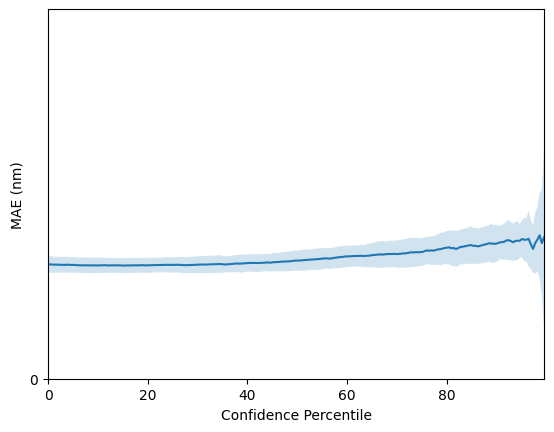

In [75]:
evaluate_model(X_fragprints, y, 100, 20)

We observe that while the BNN model is able to achieve relatively low errors in prediction, the errors are not very well calibrated, resulting in poor correlation of the MAE with the confidence percentile from the model uncertainty. 